In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
params = {
    'meta-llama/Llama-3.1-8B-Instruct': 8,
    'Qwen/Qwen3-8B':8,
    'google/gemma-2-9b-it':9,
    'Qwen/Qwen3-14B':14,
    'mistralai/Ministral-8B-Instruct-2410':8,
    'Qwen/QwQ-32B':32,
    'Qwen/Qwen3-32B':32,
    'mistralai/Mistral-Small-3.1-24B-Instruct-2503': 24,
    'google/gemma-2-27b-it':27,
}

In [4]:
df = pd.read_csv('dataset_inference_results.csv')

df.keys()

Index(['active_energy', 'total_energy', 'active_power_avg',
       'active_power_peak', 'active_power_p50', 'active_power_p95',
       'total_power_avg', 'total_power_peak', 'total_power_p50',
       'total_power_p95', 'active_gpu_util_avg', 'active_gpu_util_peak',
       'active_gpu_util_p50', 'active_gpu_util_p95', 'active_mem_util_avg',
       'active_mem_util_peak', 'active_mem_util_p50', 'active_mem_util_p95',
       'active_mem_avg', 'active_mem_peak', 'active_mem_p50', 'active_mem_p95',
       'total_mem_avg', 'total_mem_peak', 'total_mem_p50', 'total_mem_p95',
       'total_gpu_util_avg', 'total_gpu_util_peak', 'total_gpu_util_p50',
       'total_gpu_util_p95', 'total_mem_util_avg', 'total_mem_util_peak',
       'total_mem_util_p50', 'total_mem_util_p95', 'In Tokens Total',
       'In Tokens Avg', 'In Tokens P50', 'In Tokens P95', 'In Tokens Max',
       'In Tokens Min', 'Out Tokens Total', 'Out Tokens Avg', 'Out Tokens P50',
       'Out Tokens P95', 'Out Tokens Max', 'Out Toke

In [5]:
df['Tokens Total'] = df['In Tokens Total'] + df['Out Tokens Total']
df['Active Energy/Tok (in+out) J/1000'] = df['active_energy'] / df['Tokens Total'] * 1000
df['Active Energy/Tok (in) J/1000'] = df['active_energy'] / df['In Tokens Total'] * 1000
df['Active Energy/Tok (out) J/1000'] = df['active_energy'] / df['Out Tokens Total'] * 1000

df['# params'] = df.apply(lambda x: params[x['Model Name']], axis=1)

df['Throughoput per Watt'] = df['Throughput (out) tok/s'] / df['active_power_avg']

def shorten_name(name):
    return name.split('/')[-1].replace('-', ' ').replace('Instruct', '').replace('it', '').replace('2503','').replace('2410','').strip()

df['Model Name Short'] = df['Model Name'].apply(shorten_name)

In [6]:
df['Model Name'].unique()

array(['meta-llama/Llama-3.1-8B-Instruct', 'Qwen/Qwen3-8B',
       'google/gemma-2-9b-it', 'Qwen/Qwen3-14B',
       'mistralai/Ministral-8B-Instruct-2410', 'Qwen/QwQ-32B',
       'Qwen/Qwen3-32B', 'mistralai/Mistral-Small-3.1-24B-Instruct-2503',
       'google/gemma-2-27b-it'], dtype=object)

In [7]:
model_name = 'Qwen/QwQ-32B'

model_df = df[df['Model Name'] == model_name]
batch_sizes = model_df['Batch Size'].unique()
tp_sizes = model_df['TP Size'].unique()

model_df.head()

,active_energy,total_energy,active_power_avg,active_power_peak,active_power_p50,active_power_p95,total_power_avg,total_power_peak,total_power_p50,total_power_p95,...,PP Size,EP,Batch Size,Tokens Total,Active Energy/Tok (in+out) J/1000,Active Energy/Tok (in) J/1000,Active Energy/Tok (out) J/1000,# params,Throughoput per Watt,Model Name Short
76,220445.189347,315704.980847,473.058337,634.153,468.1175,519.9667,677.478490,839.178,672.5655,724.18655,...,1,1,16.0,576438,382.426539,658.584004,912.015909,32,1.099351,QwQ 32B
77,138309.600500,194043.042033,506.628573,691.516,504.5725,567.6590,710.780374,896.319,708.7895,771.51175,...,1,1,32.0,576438,239.938381,413.202442,572.208250,32,1.752755,QwQ 32B
78,96385.584500,132007.973500,552.352920,691.376,562.0440,624.2756,756.492685,895.686,766.1360,828.64200,...,1,1,64.0,576438,167.208936,287.953683,398.762099,32,2.522409,QwQ 32B
79,84612.553500,114105.232581,585.554003,694.667,606.4630,666.5468,789.655588,899.015,810.7070,870.49500,...,1,1,128.0,576438,146.785176,252.781539,350.055245,32,2.881016,QwQ 32B
80,86559.618000,116865.281244,582.893051,699.687,600.8320,670.3734,786.971589,903.994,804.5880,874.48900,...,1,1,NaN,576438,150.162928,258.598430,358.110553,32,2.811011,QwQ 32B


In [8]:
batch_sizes

array([ 16.,  32.,  64., 128.,  nan])

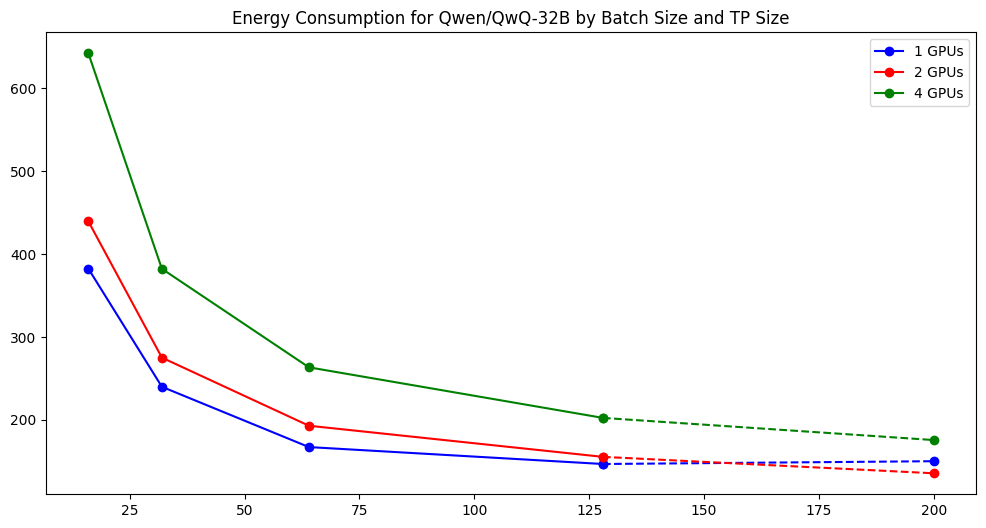

In [9]:
plt.figure(figsize=(12, 6))

color = {1: 'blue', 2: 'red', 4: 'green', 8: 'orange', 16: 'purple'}

for tp in tp_sizes:
    df_tp = model_df[(model_df['Model Name'] == model_name) & (model_df['TP Size'] == tp)]
    plt.plot(df_tp['Batch Size'], df_tp['Active Energy/Tok (in+out) J/1000'], label=f'{tp} GPUs', color = color[tp], marker='o')
    plt.plot([batch_sizes[-2],200], df_tp['Active Energy/Tok (in+out) J/1000'][-2:], linestyle ='--', color = color[tp], marker='o')

plt.title(f'Energy Consumption for {model_name} by Batch Size and TP Size')
plt.legend()
plt.show()

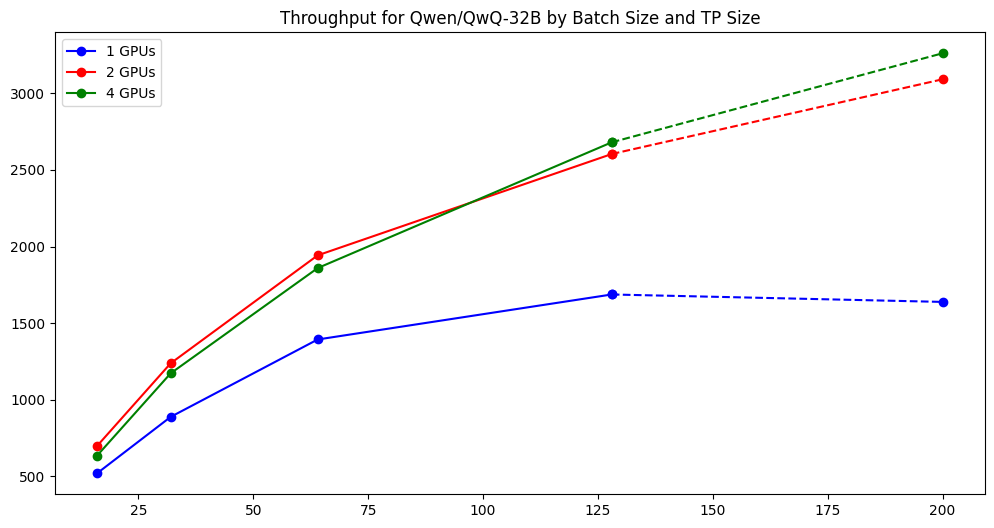

In [10]:
plt.figure(figsize=(12, 6))

for tp in tp_sizes:
    df_tp = model_df[(model_df['Model Name'] == model_name) & (model_df['TP Size'] == tp)]
    plt.plot(batch_sizes, df_tp['Throughput (out) tok/s'], label=f'{tp} GPUs', color = color[tp], marker='o')
    plt.plot([batch_sizes[-2],200], df_tp['Throughput (out) tok/s'][-2:], linestyle ='--', color = color[tp], marker='o')

plt.title(f'Throughput for {model_name} by Batch Size and TP Size')
plt.legend()
plt.show()

In [11]:
#plt.figure(figsize=(12, 6))

#for tp in tp_sizes:
#    df_tp = model_df[(model_df['Model Name'] == model_name) & (model_df['TP Size'] == tp)]
#    plt.plot(batch_sizes, df_tp['active_gpu_util_p95'], label=f'{tp} GPUs', color = color[tp], marker='o')
#    plt.plot([batch_sizes[-2],200], df_tp['active_gpu_util_p95'][-2:], linestyle ='--', color = color[tp], marker='o')

#plt.title(f'GPU util (%) for {model_name} by Batch Size and TP Size')
#plt.legend()
#plt.show()

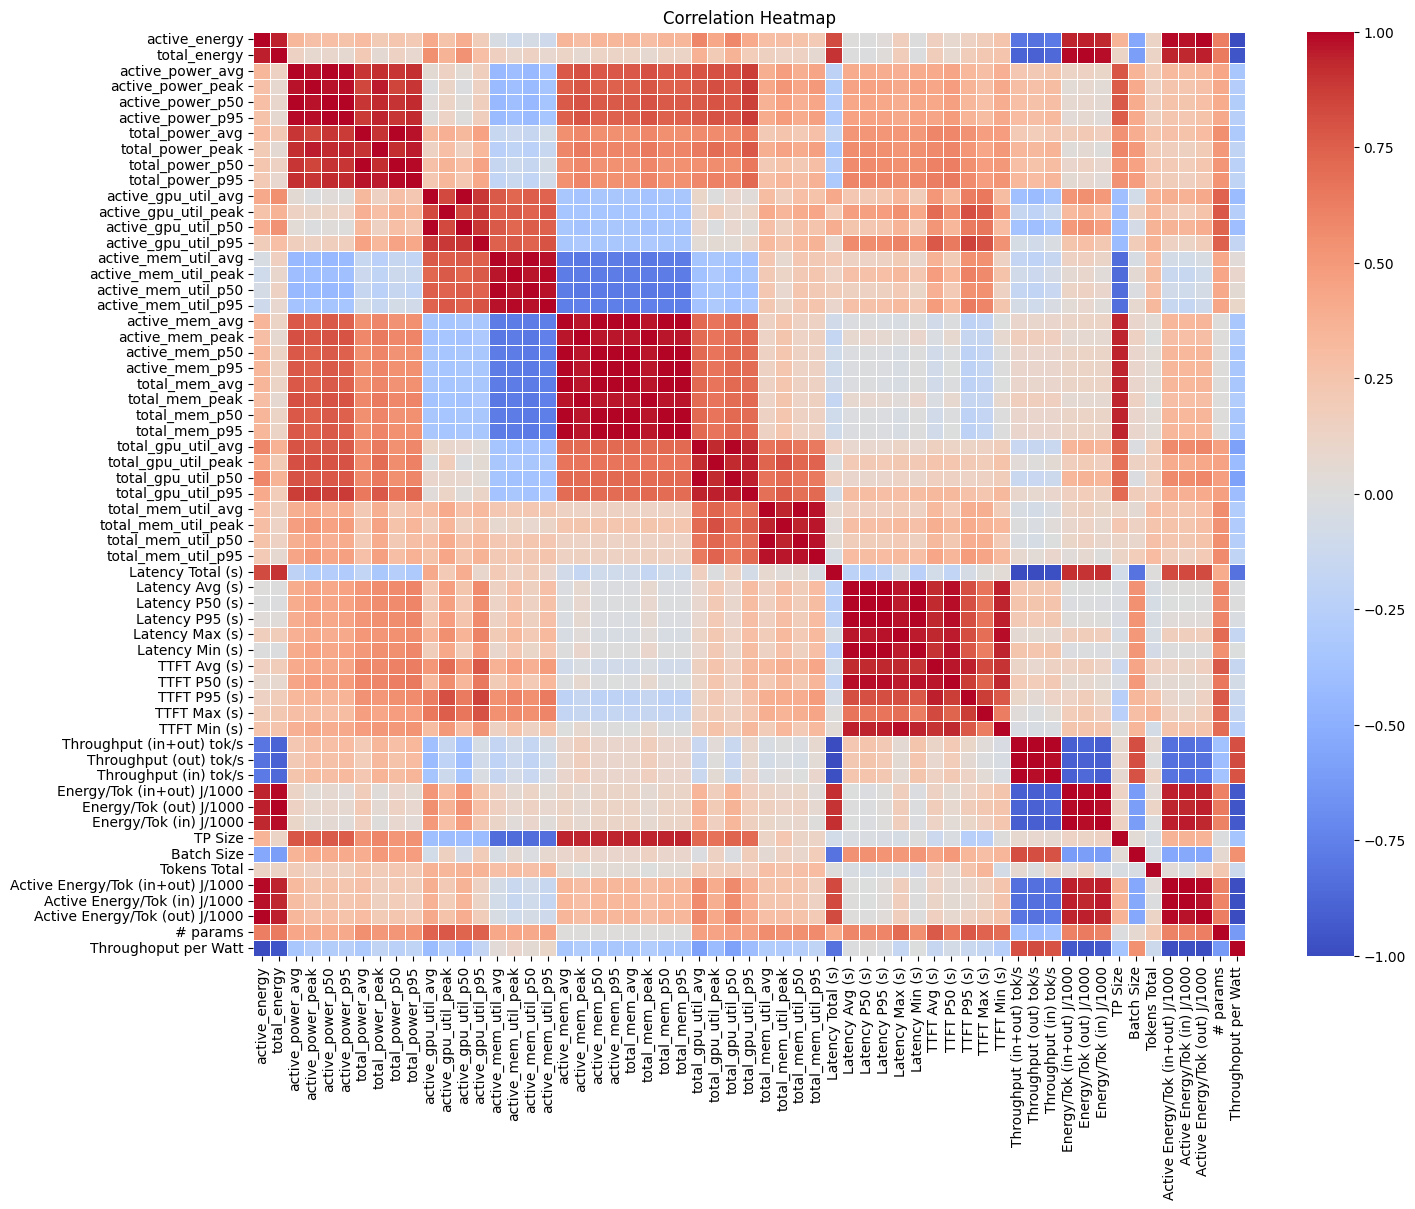

In [12]:
data = df.drop(columns=['Model Name', 'Model Name Short', 'FrameWork', 'Hardware type','In Tokens Total',
       'In Tokens Avg', 'In Tokens P50', 'In Tokens P95', 'In Tokens Max',
       'In Tokens Min', 'Out Tokens Total', 'Out Tokens Avg', 'Out Tokens P50',
       'Out Tokens P95', 'Out Tokens Max', 'Out Tokens Min', 'PP Size', 'EP'])  

plt.figure(figsize=(16, 12))
sns.heatmap(
    data.corr(method="spearman"),
    #annot=True,        # Show the correlation coefficient in each cell
    #fmt=".2f",         # Format numbers to two decimal places
    cmap="coolwarm",   # Color palette (blue = low, red = high by default)
    linewidths=0.5     # Lines between cells
)
plt.title("Correlation Heatmap")
plt.show()

In [13]:
unlimited_bs_df = df[df['Batch Size'].isna()]

unlimited_bs_df = unlimited_bs_df.sort_values(by='# params', ascending=True)

/tmp/ipykernel_41396/1442458345.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/1442458345.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(
/tmp/ipykernel_41396/1442458345.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/1442458345.py:13: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


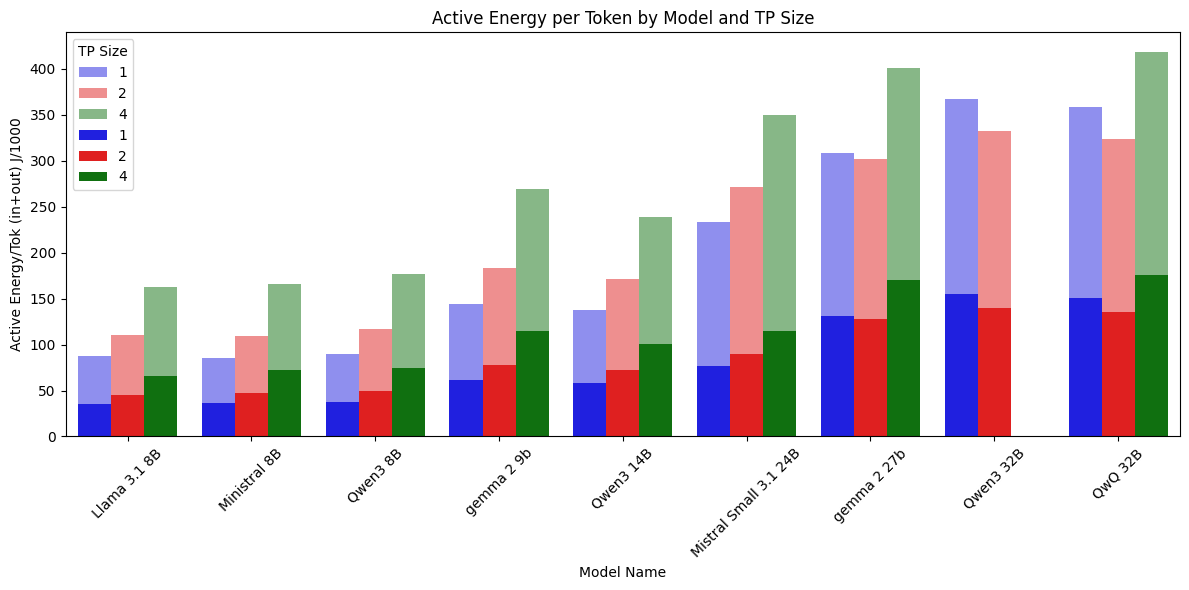

In [14]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model Name Short',
    y='Active Energy/Tok (out) J/1000',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5,
    alpha=0.5
)
sns.barplot(
    x='Model Name Short',
    y='Active Energy/Tok (in+out) J/1000',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5,
)
plt.xticks(rotation=45)
plt.title('Active Energy per Token by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('Active Energy/Tok (in+out) J/1000')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41396/919648010.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/919648010.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


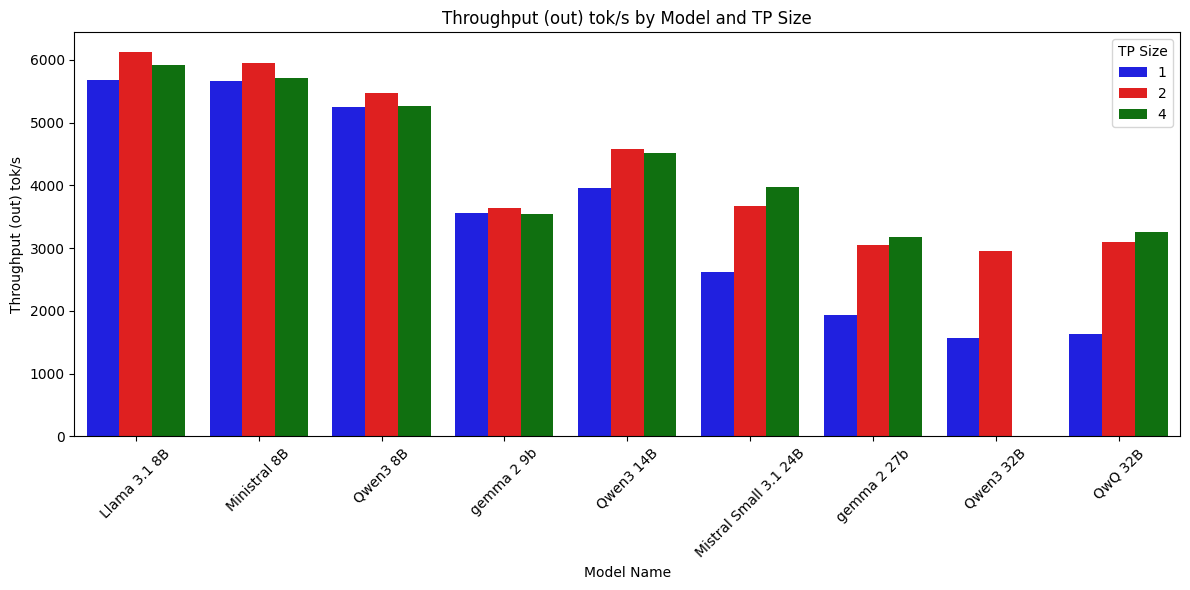

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model Name Short',
    y='Throughput (out) tok/s',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5
)
plt.xticks(rotation=45)
plt.title('Throughput (out) tok/s by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('Throughput (out) tok/s')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41396/112375966.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/112375966.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


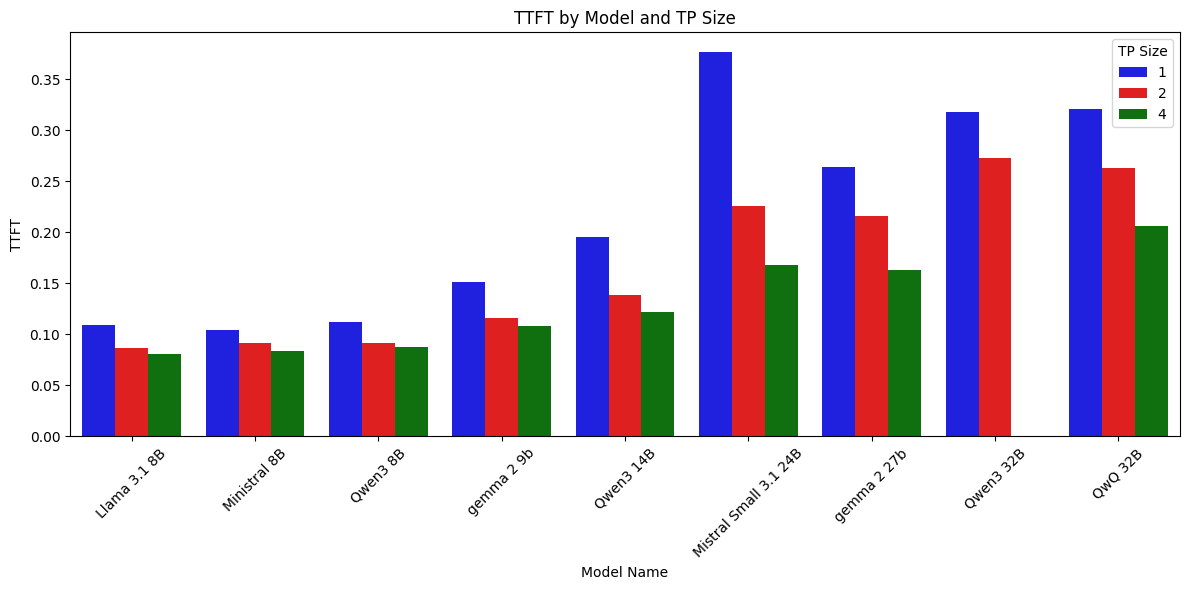

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model Name Short',
    y='TTFT P95 (s)',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5
)
plt.xticks(rotation=45)
plt.title('TTFT by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('TTFT')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41396/3316515173.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/3316515173.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(
/tmp/ipykernel_41396/3316515173.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/3316515173.py:13: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


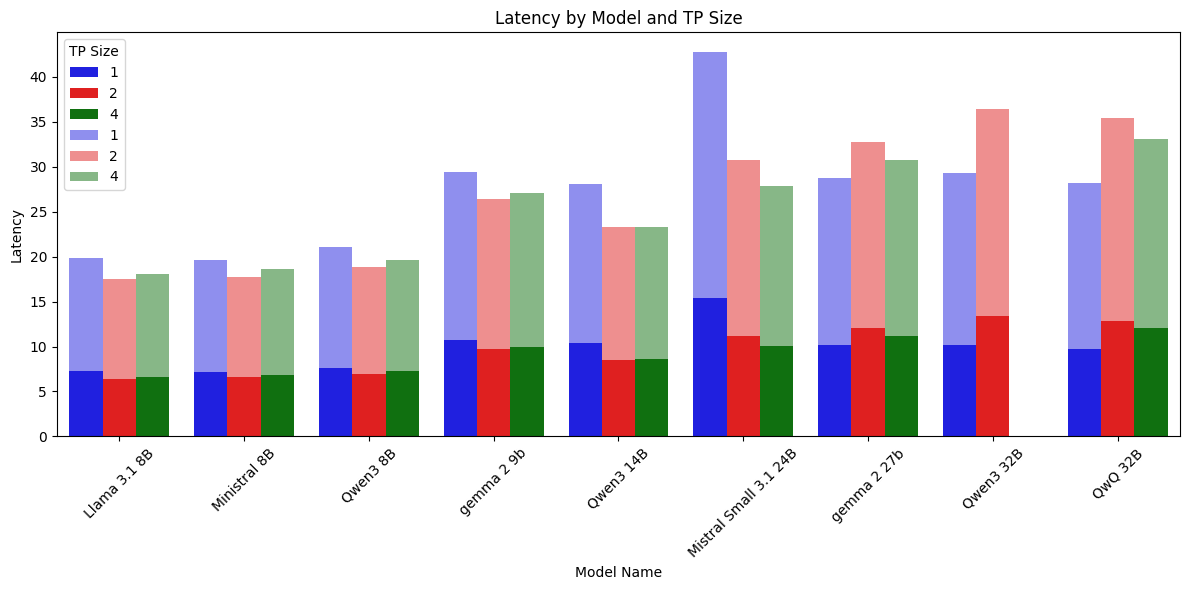

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model Name Short',
    y='Latency P50 (s)',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5,
    alpha=1
)
sns.barplot(
    x='Model Name Short',
    y='Latency P95 (s)',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5,
    alpha=0.5
)
plt.xticks(rotation=45)
plt.title('Latency by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('Latency')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41396/3235751628.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/3235751628.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(
/tmp/ipykernel_41396/3235751628.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/3235751628.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


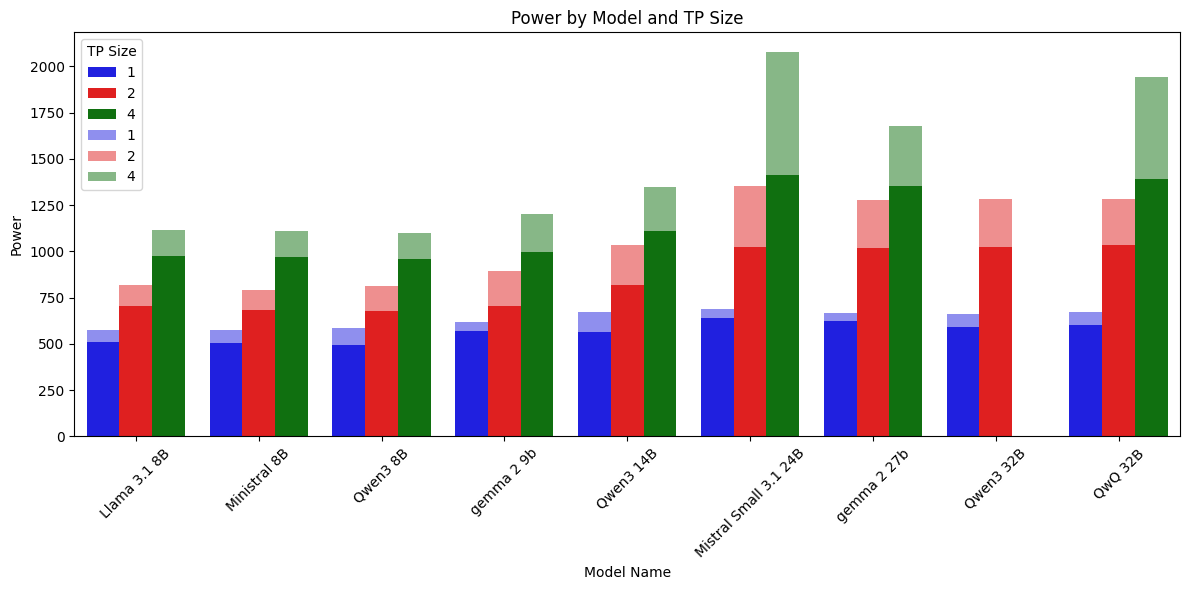

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model Name Short',
    y='active_power_p50',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5
)
sns.barplot(
    x='Model Name Short',
    y='active_power_p95',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5,
    alpha=0.5
)
plt.xticks(rotation=45)
plt.title('Power by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('Power')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41396/1888770759.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/1888770759.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


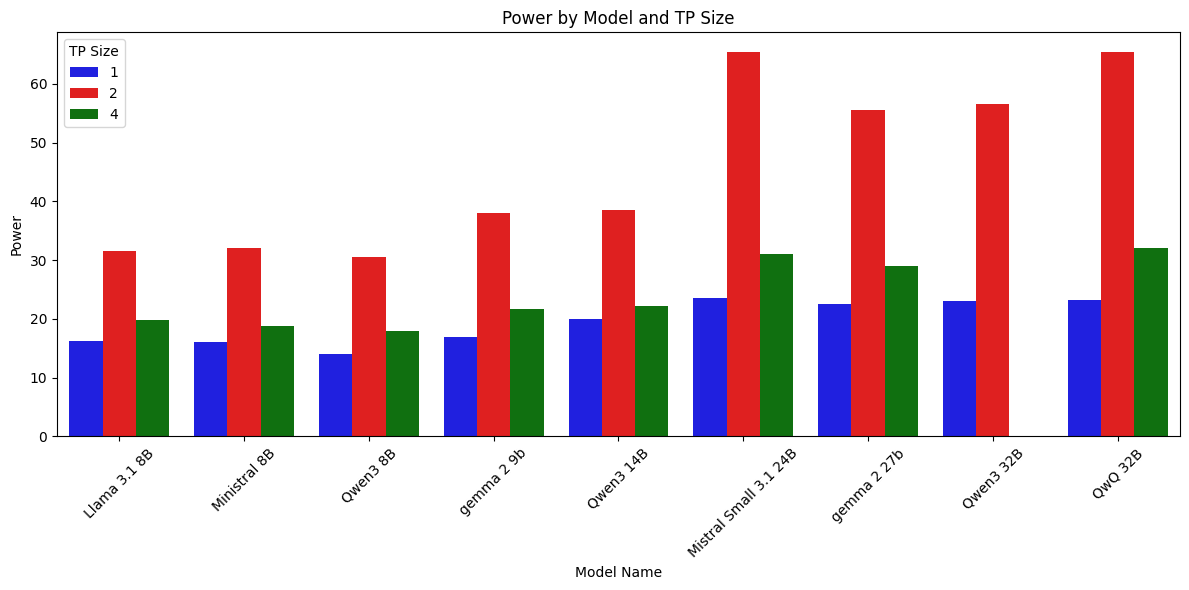

In [19]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x='Model Name Short',
    y='total_mem_util_peak',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5
)

plt.xticks(rotation=45)
plt.title('Power by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('Power')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41396/3716953983.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/3716953983.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


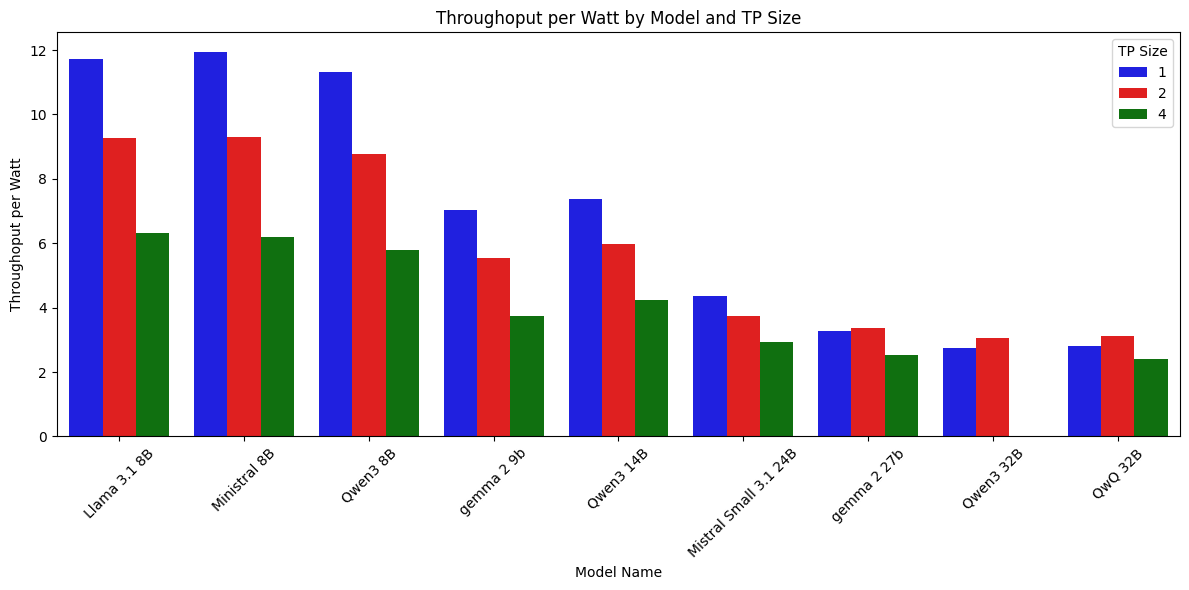

In [20]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model Name Short',
    y='Throughoput per Watt',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5
)
plt.xticks(rotation=45)
plt.title('Throughoput per Watt by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('Throughoput per Watt')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()

/tmp/ipykernel_41396/2189099420.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/2189099420.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(
/tmp/ipykernel_41396/2189099420.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_41396/2189099420.py:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


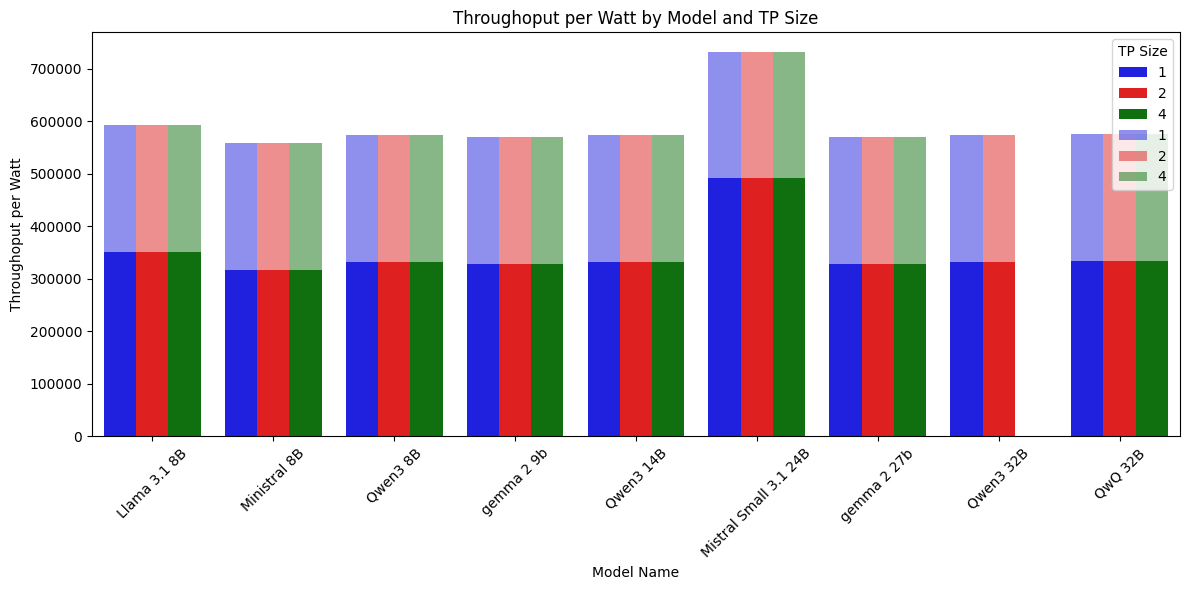

In [21]:
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Model Name Short',
    y='In Tokens Total',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5
)
sns.barplot(
    x='Model Name Short',
    y='Tokens Total',
    data=unlimited_bs_df,
    hue='TP Size',
    palette=color,
    ci=None,
    capsize=0.1,
    errwidth=1.5,
    alpha=0.5
)
plt.xticks(rotation=45)
plt.title('Throughoput per Watt by Model and TP Size')
plt.xlabel('Model Name')
plt.ylabel('Throughoput per Watt')
plt.legend(title='TP Size')
plt.tight_layout()
plt.show()